# TCN for all position

In [2]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn as nn
from torch.nn.utils import weight_norm
import torch.optim as optim
import numpy as np
from collections import OrderedDict
import os
import random
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from callback import tcn
from callback import earlystopping

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 乱数固定用の処理
# 同じ学習結果を得る
seed = 42


os.environ['PYTHONHASHSEED'] = str(seed)
# Python random
random.seed(seed)
# Numpy
np.random.seed(seed)
# Pytorch
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
torch.use_deterministic_algorithms = True
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data

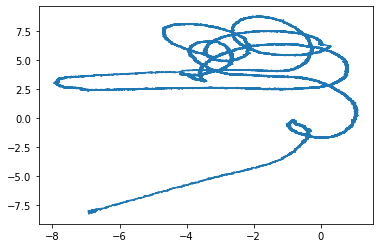

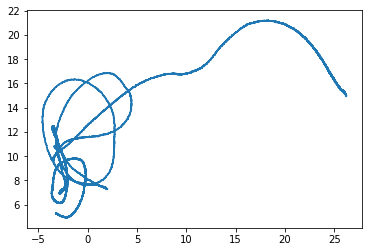

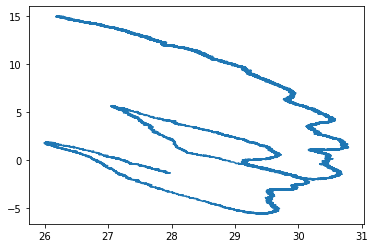

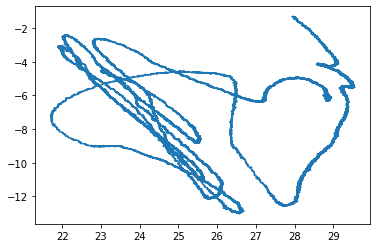

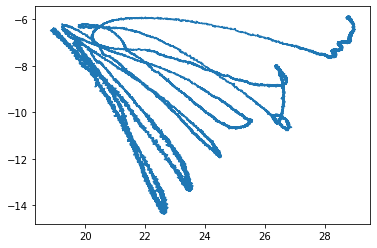

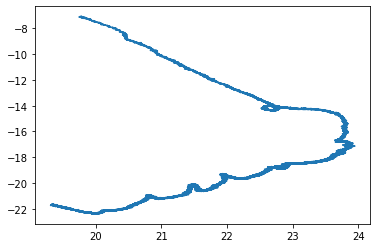

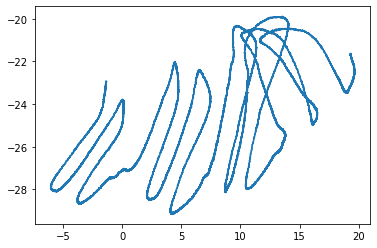

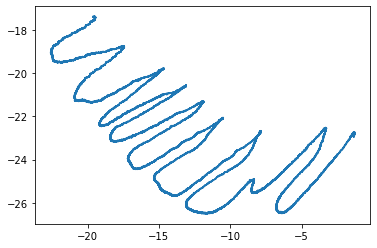

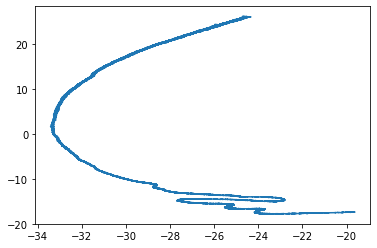

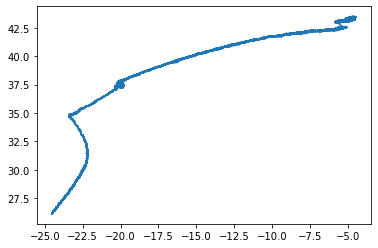

In [4]:
def mk_dataframe(path):
    df = pd.read_table(path, sep=" ", header=None)
    df = df.drop(columns=0, axis=1)
    df = df.drop(columns=3, axis=1)
    return df

position_data = np.array([[None, None]])

for i in range(10):
    df = mk_dataframe("230724/pos-{}.dat".format(i))
    df_ = df.values
    position_data = np.concatenate([position_data, df_])
    plt.plot(df_[:,0], df_[:,1])
    plt.show()

In [5]:
position_data = position_data[1:]

In [6]:
position_data.shape

(351362, 2)

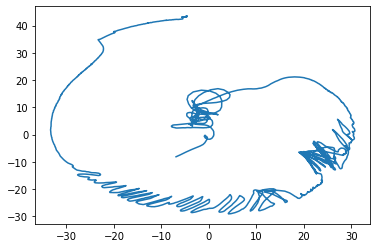

In [7]:
# 10秒に1点
plt.plot(position_data[::100,0], position_data[::100,1])

In [8]:
pos_by10s = position_data[::100]

In [9]:
pos_by10s.shape

(3514, 2)

### position data, scatter marker by 1,000 seconds

Text(0.5, 1.0, 'position data \n scatter x by 1,000 seconds')

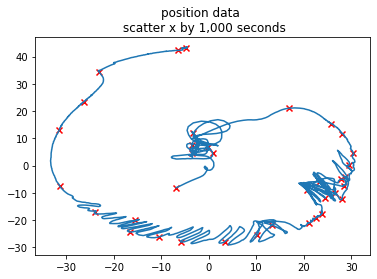

In [10]:
plt.plot(pos_by10s[:,0], pos_by10s[:,1])
# plt.scatter(pos_by10s[0,0], pos_by10s[0,1])
for i in range(0, len(pos_by10s), 100):
    plt.scatter(pos_by10s[i,0], pos_by10s[i,1], marker="x", color="red")
    
plt.title("position data \n scatter x by 1,000 seconds")

### Data be analized
**ランダムな運動を排除**

In [11]:
pos_by10s = pos_by10s[600:]

Text(0.5, 1.0, 'data be analyzed (without randomness)')

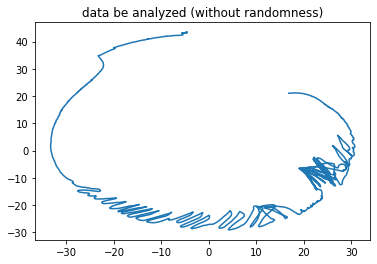

In [12]:
plt.plot(pos_by10s[:,0], pos_by10s[:,1])
plt.title("data be analyzed (without randomness)")

In [13]:
# 正規化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

pos_by10s_scaled = scaler.fit_transform(pos_by10s)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [14]:
time_step = 200

len_seq = len(pos_by10s_scaled)
data_size = len_seq - time_step

data = np.zeros((data_size, 2, time_step))
t = np.zeros((data_size, 2))

In [15]:
for i in range(data_size):
    data[i,0] = pos_by10s_scaled[i:i+time_step, 0]
    data[i,1] = pos_by10s_scaled[i:i+time_step, 1]
    t[i] = pos_by10s_scaled[i+time_step]

In [16]:
data

array([[[0.78278858, 0.79023745, 0.79661911, ..., 0.9580897 ,
         0.9585187 , 0.95854384],
        [0.6913494 , 0.6922268 , 0.69300375, ..., 0.56476084,
         0.56394768, 0.56388104]],

       [[0.79023745, 0.79661911, 0.8016556 , ..., 0.9585187 ,
         0.95854384, 0.95919766],
        [0.6922268 , 0.69300375, 0.69315287, ..., 0.56394768,
         0.56388104, 0.56361448]],

       [[0.79661911, 0.8016556 , 0.8079705 , ..., 0.95854384,
         0.95919766, 0.96007822],
        [0.69300375, 0.69315287, 0.69276225, ..., 0.56388104,
         0.56361448, 0.56325643]],

       ...,

       [[0.20851233, 0.20805142, 0.20947062, ..., 0.44766308,
         0.44614875, 0.44566556],
        [0.92293148, 0.92242086, 0.92210145, ..., 1.        ,
         0.99781173, 0.99844406]],

       [[0.20805142, 0.20947062, 0.21030153, ..., 0.44614875,
         0.44566556, 0.44741924],
        [0.92242086, 0.92210145, 0.92279537, ..., 0.99781173,
         0.99844406, 0.99848699]],

       [[0.209470

### Tensor, Dataset, Dataloader

In [20]:
# 使用するテンソル
X = torch.Tensor(np.array(data).reshape(-1, 2, time_step)).to(device)
t = torch.Tensor(np.array(t).reshape(-1, 2)).to(device)

In [21]:
n_seq = X.size(0)

train_size = int(n_seq * 0.9)
test_size = n_seq - train_size
print("train size:{}, test size: {}".format(train_size, test_size))
X_train, Y_train = X[:train_size], t[:train_size]
X_test, Y_test = X[train_size:], t[train_size:]

train size:2442, test size: 272


In [23]:
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

In [25]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed()

    # Seed other libraries with torch's seed
    random.seed(worker_seed)

    # Numpy seed must be between 0 and 2**32 - 1
    if worker_seed >= 2 ** 32:
        worker_seed = worker_seed % 2 ** 32
    np.random.seed(worker_seed)

def createDataloader(batch_size): 
    dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                             batch_size=batch_size, 
                                             shuffle=True, 
                                             num_workers=2,
                                             worker_init_fn=seed_worker,
                                             generator=torch.Generator().manual_seed(seed),)
    
    return dataloader

In [26]:
train_dataloader = createDataloader(100)

In [27]:
len(train_dataloader)

25

In [28]:
X.shape

torch.Size([2714, 2, 200])

In [39]:
for s, (x,t) in enumerate(train_dataloader):
    print(s)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


## Train and Evaluate

In [53]:
def train(model, optimizer, lr, epoch, clip=-1):
    model.train()
    batch_idx = 1 # バッチが何回カウントされたか
    total_loss = 0
    
    for i, (x, t) in enumerate(train_dataloader):
        optimizer.zero_grad()
        output = model(x, debug=False)
        
        # 出力と正解の誤差をバッチの数で割る（バッチにおける誤差の平均）
        loss = F.mse_loss(output, t)
        loss.backward()
        
        if clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            
        optimizer.step()
        batch_idx += 1
        total_loss += loss.item()
        
        """
        if (epoch % 5 == 0 or epoch == 1) and batch_idx % 5 == 0:
            cur_loss = total_loss / batch_idx
            processed = min(i+batch_size, X_train.size(0))
            print('Train Epoch: {:2d} [{:6d}/{:6d}] \t Learning rate: {:.4f}\t Train Loss: {:.6f}'.format(
                epoch, batch_idx, len(train_dataloader), lr, cur_loss))
            # total_loss = 0
        """
    return total_loss / batch_idx
            
def evaluate(epoch, train_loss):
    model.eval()
    with torch.no_grad():
        test_loss = .0
        for i, (x,t) in enumerate(test_dataset):
            output = model(x.reshape(1,2,-1))
            t_loss = F.mse_loss(output, t.reshape(1,2))
            test_loss += t_loss.item()
            
        test_loss /= len(test_dataset)  
        
        if epoch % 5 == 0 or epoch == 1:
            print('\n [epoch: {}] Train loss: {:.6f} \t Test set: Average loss: {:.6f}\n'.format(epoch, train_loss, test_loss))
        return test_loss

## Model

In [55]:
epochs = 50
lr = 1e-3

model = tcn.myTCN(input_size=2, output_size=2, num_channels=[15]*7, kernel_size=5, dropout=0.0)
optimizer = getattr(optim, 'Adam')(model.parameters(), lr=lr)

In [56]:
loss = {"val_loss":[], "train_loss":[]}
es = earlystopping.EarlyStopping(patience=5, verbose=1)

for epoch in range(1, epochs + 1):
    train_loss = train(model, optimizer, lr=lr, epoch=epoch, clip=-1)
    tloss = evaluate(epoch, train_loss)
    
    loss["train_loss"].append(train_loss)
    loss["val_loss"].append(tloss)
    # if es(tloss):
    #     break


 [epoch: 1] Train loss: 0.160435 	 Test set: Average loss: 0.310867


 [epoch: 5] Train loss: 0.025243 	 Test set: Average loss: 0.317323


 [epoch: 10] Train loss: 0.000794 	 Test set: Average loss: 0.006893


 [epoch: 15] Train loss: 0.000680 	 Test set: Average loss: 0.007586


 [epoch: 20] Train loss: 0.000604 	 Test set: Average loss: 0.007577


 [epoch: 25] Train loss: 0.000496 	 Test set: Average loss: 0.008791


 [epoch: 30] Train loss: 0.000474 	 Test set: Average loss: 0.004826


 [epoch: 35] Train loss: 0.000501 	 Test set: Average loss: 0.006531


 [epoch: 40] Train loss: 0.000447 	 Test set: Average loss: 0.006774


 [epoch: 45] Train loss: 0.000453 	 Test set: Average loss: 0.004406


 [epoch: 50] Train loss: 0.000371 	 Test set: Average loss: 0.005558



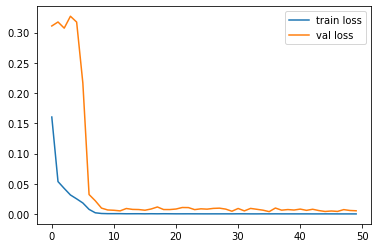

In [57]:
plt.plot(loss["train_loss"], label="train loss")
plt.plot(loss["val_loss"], label="val loss")
plt.legend()

## Prediction

In [66]:
gen_time = 2000

gen = [[None, None] for i in range(time_step)]
# z = X_test[0].reshape(1,2,-1)
z = torch.Tensor(data[0].reshape(1,2,-1))

for i in range(gen_time):
    model.eval()
    pred = model(z).data.cpu().numpy()
    z = np.concatenate([z.numpy().reshape(2,-1), pred.reshape(2,-1)], 1)
    z = z[:,1:]
    # print(z.shape)
    z = torch.Tensor(z.reshape(1,2,-1))
    gen.append([pred[0,0], pred[0,1]])

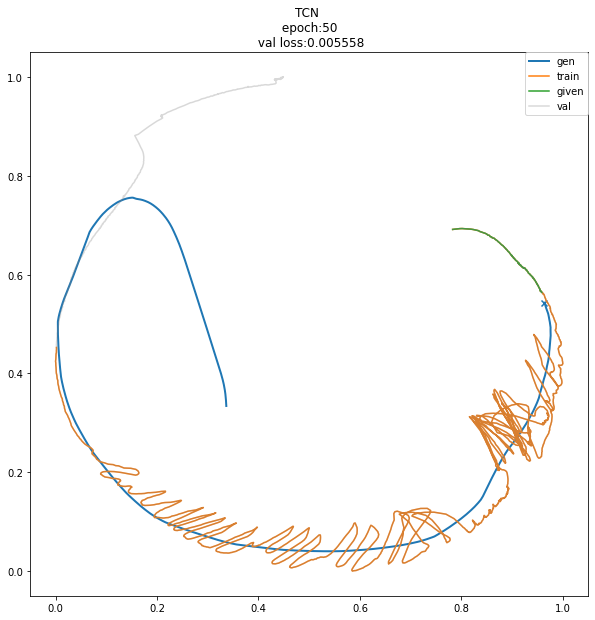

In [68]:
plt.figure(figsize=(10,10))
gen = np.array(gen)
plt.plot(gen[:,0], gen[:,1], label="gen", linewidth=2)
plt.scatter(gen[time_step,0], gen[time_step, 1], marker="x")


plt.plot(pos_by10s_scaled[:train_size, 0], pos_by10s_scaled[:train_size, 1], label="train")

plt.plot(pos_by10s_scaled[:time_step, 0], pos_by10s_scaled[:time_step, 1], label="given")

plt.plot(pos_by10s_scaled[:,0], pos_by10s_scaled[:,1], color="gray", alpha=0.3, label="val")
plt.title("TCN \n epoch:{} \n val loss:{:6f}".format(epochs, loss["val_loss"][-1]))
plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0)

In [70]:
len(gen)

2200